In [60]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

## Data

In [2]:
# Data loading
(x_train, y_train) , (x_test, y_test)= tf.keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))



print("Dimensions des données")
print("X_train shape: ", x_train.shape)
print("X_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
Dimensions des données
X_train shape:  (60000, 28, 28, 1)
X_test shape:  (10000, 28, 28, 1)
y_train shape:  (60000,)
y_test shape:  (10000,)


## Distillation class

In [3]:
class Distiller(tf.keras.Model):
  def __init__(self, teacher, student):
      super(Distiller, self).__init__()
      
      # Attributs de la classe Distiller
      self.teacher = teacher
      self.student = student
      
  # Compilation du model
  def compile( self, optimizer, metrics, distillation_loss_fn, student_loss_fn, alpha = 0.1, temperature= 20):

    super(Distiller,self).compile(optimizer = optimizer, metrics= metrics )
    # losses
    self.distillation_loss_fn = distillation_loss_fn
    self.student_loss_fn = student_loss_fn

    # Hyperparameters
    self.temperature = temperature
    self.alpha = alpha
  
  # Training Step
  def train_step(self, data):
    # Unpack data
    x, y = data

    # Forward pass of teacher
    teacher_predictions = self.teacher(x, training=False)
    with tf.GradientTape() as tape:
      # student forward
      student_predictions = self.student(x, training= True)

      # Compute losses
      student_loss = self.student_loss_fn(y, student_predictions)
      distillation_loss = self.distillation_loss_fn(
          tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
          tf.nn.softmax(student_predictions / self.temperature, axis=1),
        )

      loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

    # Compute gradients
    trainable_vars = self.student.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Update the metrics configured in `compile()`.
    self.compiled_metrics.update_state(y, student_predictions)

    # Return a dict of performance
    results = {m.name: m.result() for m in self.metrics}
    results.update(
        {"student_loss": student_loss, "distillation_loss": distillation_loss}
    )
    return results

  # Test Step
  def test_step(self, data):
    
    # Unpack the data
    x, y = data

    # Compute predictions
    y_prediction = self.student(x, training=False)

    # Calculate the loss
    student_loss = self.student_loss_fn(y, y_prediction)

    # Update the metrics.
    self.compiled_metrics.update_state(y, y_prediction)

    # Return a dict of performance
    results = {m.name: m.result() for m in self.metrics}
    results.update({"student_loss": student_loss})
    return results




## Testing the class

### Training the teacher

In [4]:
# Create the teacher
teacher = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10),
    ],
    name="teacher",
)

# Create the student
student = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10),
    ],
    name="student",
)

# Clone student for later comparison
student_scratch = tf.keras.models.clone_model(student)


## Teacher Training

In [5]:
# Paramètres d'entrainement
Epochs = 10
Batch = 64

In [6]:
# Train teacher as usual
teacher.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
teacher.summary()

# Train and evaluate teacher on data.
Teacher_hist = teacher.fit(x_train, y_train, epochs=Epochs, batch_size = Batch)
teacher.evaluate(x_test, y_test)


Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 256)       2560      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 256)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 512)         1180160   
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 10)                250890    
                                                           

[0.148451030254364, 0.9753000140190125]

## Training the student with KD

In [7]:
dist = Distiller(teacher, student)
dist.compile(
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
    distillation_loss_fn = tf.keras.losses.KLDivergence(),
    student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    alpha = 0.1,
    temperature = 20)



# Distill teacher to student
dist_hist = dist.fit(x_train, y_train, epochs=Epochs, batch_size = Batch)

# Evaluate student on test dataset
dist.evaluate(x_test, y_test)

Epoch 1/10
938/938 [==============================] - 15s 14ms/step - sparse_categorical_accuracy: 0.8884 - student_loss: 0.5680 - distillation_loss: 0.1069
Epoch 2/10
938/938 [==============================] - 13s 14ms/step - sparse_categorical_accuracy: 0.9568 - student_loss: 0.2330 - distillation_loss: 0.0368
Epoch 3/10
938/938 [==============================] - 13s 14ms/step - sparse_categorical_accuracy: 0.9679 - student_loss: 0.1683 - distillation_loss: 0.0254
Epoch 4/10
938/938 [==============================] - 16s 17ms/step - sparse_categorical_accuracy: 0.9736 - student_loss: 0.1329 - distillation_loss: 0.0204
Epoch 5/10
938/938 [==============================] - 13s 14ms/step - sparse_categorical_accuracy: 0.9765 - student_loss: 0.1139 - distillation_loss: 0.0175
Epoch 6/10
938/938 [==============================] - 13s 14ms/step - sparse_categorical_accuracy: 0.9788 - student_loss: 0.1021 - distillation_loss: 0.0158
Epoch 7/10
938/938 [==============================] - 13s 

[0.9803000092506409, 0.0005885250284336507]

## Entraînement standard du student model

In [9]:
# Training studen model from scratch
student_scratch.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
  )

scrratch_stud_hist = student_scratch.fit(x_train, y_train, epochs=Epochs, batch_size = Batch)

# Evaluate student on test dataset
student_scratch.evaluate(x_test, y_test)

Epoch 1/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3007 - sparse_categorical_accuracy: 0.9137
Epoch 2/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0991 - sparse_categorical_accuracy: 0.9702
Epoch 3/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0768 - sparse_categorical_accuracy: 0.9765
Epoch 4/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0685 - sparse_categorical_accuracy: 0.9790
Epoch 5/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0625 - sparse_categorical_accuracy: 0.9809
Epoch 6/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0570 - sparse_categorical_accuracy: 0.9821
Epoch 7/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0530 - sparse_categorical_accuracy: 0.9836
Epoch 8/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0507 - sparse_categorical_accuracy: 0.9846
Epoch 9/10
938/938 [============================

[0.054002098739147186, 0.9818000197410583]

## Comparaison du KD et de l'entrainement standard

In [35]:
def plot_hist(los1,los2, accur1, accur2):
  plt.figure(figsize= (20,7))
  plt.subplot(121)
  plt.plot(accur1, label='KD Accuracy')
  plt.plot(accur2, label= 'Scratch Accuracy')

  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.legend()


  plt.subplot(122)
  plt.plot(los1, label='KD Loss')
  plt.plot(los2,  label= 'Scratch Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.grid()
  plt.legend()
  plt.show()


In [36]:
print(dist_hist.history.keys())
print(scrratch_stud_hist.history.keys())

dict_keys(['sparse_categorical_accuracy', 'student_loss', 'distillation_loss'])
dict_keys(['loss', 'sparse_categorical_accuracy'])


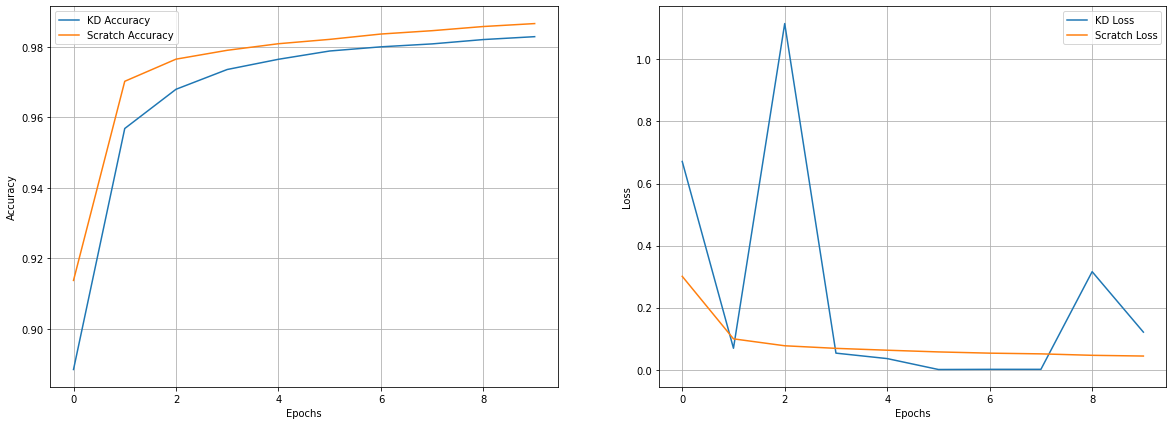

In [37]:
plot_hist(dist_hist.history['student_loss'], scrratch_stud_hist.history['loss'] ,dist_hist.history['sparse_categorical_accuracy'] , scrratch_stud_hist.history['sparse_categorical_accuracy'])